In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
task1 = pd.read_csv('task1_dataset.csv')
poi = pd.read_csv('cell_POIcat.csv')

### Select the training data

In [ ]:
task1 = task1[task1['x'] != 999]

### Home and work location detection

In [ ]:
task1_night = task1[(task1['t'] <= 13) | (task1['t'] >= 38)]
task1_night_count = task1_night.groupby(['uid', 'x', 'y']).count().reset_index()
home_idx = task1_night_count.groupby(['uid'])['t'].idxmax()
home_locations = task1_night_count.loc[home_idx,:]
home_locations = home_locations[home_locations['x'] < 250].reset_index(drop=True)

In [ ]:
task1_day = task1[(task1['t'] > 13) & (task1['t'] < 38)]
task1_day_count = task1_day.groupby(['uid', 'x', 'y']).count().reset_index()
work_idx = task1_day_count.groupby(['uid'])['t'].idxmax()
work_locations = task1_day_count.loc[work_idx,:]
work_locations = work_locations[work_locations['x'] < 250].reset_index(drop=True)

### Select users that have work and home, and identify weekend

In [ ]:
users = np.array(list(set(home_locations['uid']).intersection(set(work_locations['uid']))))

In [ ]:
task1['weekend'] = task1['d'].apply(lambda x: True if (x%7 == 0) | (x%7 ==1) else False)

In [ ]:
task1_weekday = task1[(task1['uid'].isin(users))& (task1['weekend'] == False)]
task1_weekend = task1[(task1['uid'].isin(users))& (task1['weekend'] == True)]

### Construct a typical day for users

In [ ]:
def typical_day(task1):
    typical_day_count = task1.groupby(['uid','t','x','y']).count().reset_index()
    typical_day_id = typical_day_count.groupby(['uid', 't'])['d'].idxmax()
    typical_day = typical_day_count.loc[typical_day_id,:]
    return typical_day

In [ ]:
task1_weekday_label = typical_day(task1_weekday)
task1_weekend_label = typical_day(task1_weekend)

### Label locations with home and work

In [ ]:
task1_weekday_label_home = task1_weekday_label.merge(home_locations, how='left', on=['uid','x','y'])
task1_weekday_label_home['label'] = task1_weekday_label_home['d_y'].isnull().apply(lambda x: 'none' if x == True else 'home')
task1_weekday_label_home = task1_weekday_label_home[['uid','t_x','x','y','label']]
task1_weekday_label_home.rename(columns = {'t_x':'t'}, inplace = True)

In [ ]:
task1_weekend_label_home = task1_weekend_label.merge(home_locations, how='left', on=['uid','x','y'])
task1_weekend_label_home['label'] = task1_weekend_label_home['d_y'].isnull().apply(lambda x: 'none' if x == True else 'home')
task1_weekend_label_home = task1_weekend_label_home[['uid','t_x','x','y','label']]
task1_weekend_label_home.rename(columns = {'t_x':'t'}, inplace = True)

In [ ]:
task1_weekday_label_work = task1_weekday_label_home.merge(work_locations, how='left', on=['uid','x','y'])
task1_weekday_label_work['label'] = np.where(~pd.isna(task1_weekday_label_work['t_y']), 'work', task1_weekday_label_work['label'])
task1_weekday_label_work = task1_weekday_label_work[['uid','t_x','x','y','label']]
task1_weekday_label_work.rename(columns = {'t_x':'t'}, inplace = True)

In [ ]:
task1_weekend_label_work = task1_weekend_label_home.merge(work_locations, how='left', on=['uid','x','y'])
task1_weekend_label_work['label'] = np.where(~pd.isna(task1_weekend_label_work['t_y']), 'work', task1_weekend_label_work['label'])
task1_weekend_label_work = task1_weekend_label_work[['uid','t_x','x','y','label']]
task1_weekend_label_work.rename(columns = {'t_x':'t'}, inplace = True)

### Label OR and OE

In [ ]:
first_weekday_visit_grouped = task1_weekday.groupby(['uid','x','y']).count().reset_index()
weekday_one_visit = first_weekday_visit_grouped[first_weekday_visit_grouped['t'] == 1][['uid','x','y']]

In [ ]:
first_weekend_visit_grouped = task1_weekend.groupby(['uid','x','y']).count().reset_index()
weekend_one_visit = first_weekend_visit_grouped[first_weekend_visit_grouped['t'] == 1][['uid','x','y']]

In [ ]:
task1_weekday_label_OE = task1_weekday_label_work.merge(weekday_one_visit.reset_index(), how='left', on=['uid','x','y'])
task1_weekday_label_OE['label'] = np.where(~pd.isna(task1_weekday_label_OE['index']), 'E', task1_weekday_label_OE['label'])
task1_weekday_label_OE['label'] = np.where(task1_weekday_label_OE['label'] == 'none', 'R',task1_weekday_label_OE['label'])
task1_weekday_label = task1_weekday_label_OE[['uid','t','x','y','label']]

In [ ]:
task1_weekend_label_OE = task1_weekend_label_work.merge(weekend_one_visit.reset_index(), how='left', on=['uid','x','y'])
task1_weekend_label_OE['label'] = np.where(~pd.isna(task1_weekend_label_OE['index']), 'E', task1_weekend_label_OE['label'])
task1_weekend_label_OE['label'] = np.where(task1_weekend_label_OE['label'] == 'none', 'R',task1_weekend_label_OE['label'])
task1_weekend_label = task1_weekend_label_OE[['uid','t','x','y','label']]

### Impute the missing times

In [288]:
weekday_label_array = np.empty(shape=(task1_weekday_label['uid'].nunique(), 48), dtype=str)
from tqdm import tqdm
for i in tqdm(range(len(users))):
    userdf = task1_weekday_label[task1_weekday_label['uid'] == users[i]].reset_index(drop=True)
    weekday_label_array[i, 0:userdf['t'][0]+1] = userdf['label'][0]
    index = userdf['uid'][0]
    
    for j in range(userdf.shape[0]):
        # x = userdf['x'][j]
        # y = userdf['y'][j]
        la = userdf['label'][j]
        t = userdf['t'][j]

        weekday_label_array[i, index:t+1] = la
        index = t+1
    weekday_label_array[i,index:] = la


100%|██████████| 99987/99987 [02:49<00:00, 588.51it/s]


In [291]:
weekend_user = task1_weekend_label['uid'].unique()
weekend_label_array = np.empty(shape=(task1_weekend_label['uid'].nunique(), 48), dtype=str)
from tqdm import tqdm
for i in tqdm(range(len(weekend_user))):
    userdf = task1_weekend_label[task1_weekend_label['uid'] == weekend_user[i]].reset_index(drop=True)
    weekend_label_array[i, 0:userdf['t'][0]+1] = userdf['label'][0]
    index = userdf['uid'][0]
    
    for j in range(userdf.shape[0]):
        # x = userdf['x'][j]
        # y = userdf['y'][j]
        la = userdf['label'][j]
        t = userdf['t'][j]

        weekend_label_array[i, index:t+1] = la
        index = t+1
    
    weekend_label_array[i,index:] = la


100%|██████████| 99986/99986 [02:43<00:00, 610.76it/s]


### kmode clustering for weekday and weekends

In [305]:
from kmodes.kmodes import KModes
cost = []
for k in tqdm(range(2,11)):
    kmode = KModes(n_clusters=k, init = "random")
    kmode.fit_predict(weekday_label_array)
    cost.append(kmode.cost_)

100%|██████████| 9/9 [27:19<00:00, 182.22s/it]


In [309]:
cost2 = []
for k in tqdm(np.arange(2,11)):
    kmode2 = KModes(n_clusters=k, init = "random")
    kmode2.fit_predict(weekend_label_array)
    cost2.append(kmode2.cost_)

100%|██████████| 9/9 [26:24<00:00, 176.09s/it]


Text(0.5, 1.0, 'KMode Clustering for Weekday Labels')

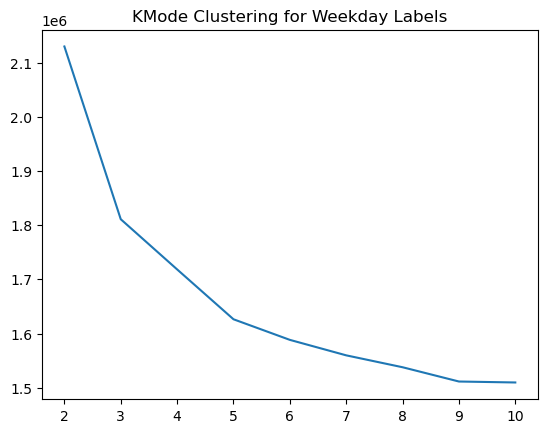

In [308]:
plt.plot(np.arange(2,11), cost)
plt.title('KMode Clustering for Weekday Labels')

Text(0.5, 1.0, 'KMode Clustering for Weekend Labels')

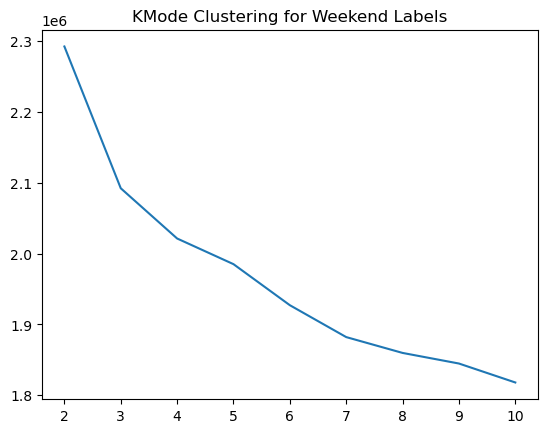

In [310]:
plt.plot(np.arange(2,11), cost2)
plt.title('KMode Clustering for Weekend Labels')

### Calculate the transition matrix based on the k selected

In [292]:
kmode = KModes(n_clusters=5, init = "random")
predicted_mode = kmode.fit_predict(weekday_label_array)
kmode.cluster_centroids_

array([['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R'],
       ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w'],
       ['h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h',
        'h', 'R', 'R', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'R', 'h', 'h',
        'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'],
       ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w

In [293]:
np.save('weekday_user/cluster_label.npy', kmode.cluster_centroids_)

In [345]:
import importlib
import utils
importlib.reload(utils)
from utils import data_to_transition_matrix
transition_matrix_weekday = np.zeros(shape=(5,3,4,4))

for i in range(5):
    user_in_cluster = users[predicted_mode==i]
    np.save(f'weekday_user/cluster_{i}.npy', user_in_cluster)

    label_in_cluster = weekday_label_array[predicted_mode == i,:]
    cluster_transition_matrix = data_to_transition_matrix(label_in_cluster)
    transition_matrix_weekday[i] = cluster_transition_matrix

np.save('weekday_user/transition_matrix.npy', transition_matrix_weekday)

In [301]:
kmode_weekend = KModes(n_clusters=5, init = "random")
predicted_mode_weekend = kmode_weekend.fit_predict(weekend_label_array)
kmode_weekend.cluster_centroids_

array([['h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'h',
        'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'],
       ['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
        'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R'],
       ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w'],
       ['h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h',
        'h', 'R', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w',
        'w', 'w', 'w', 'w', 'w', 'w

In [302]:
np.save('weekend_user/cluster_label.npy', kmode_weekend.cluster_centroids_)

In [346]:
transition_matrix_weekend = np.zeros(shape=(5,3,4,4))
for i in range(5):
    user_in_cluster = weekend_user[predicted_mode_weekend==i]
    np.save(f'weekend_user/cluster_{i}.npy', user_in_cluster)

    label_in_cluster = weekend_label_array[predicted_mode_weekend == i,:]
    cluster_transition_matrix = data_to_transition_matrix(label_in_cluster)
    transition_matrix_weekend[i] = cluster_transition_matrix

np.save('weekend_user/transition_matrix.npy', transition_matrix_weekend)

### Obtain the initial state vectors

In [375]:
def append_home_locations(data, df_poi):
    merged = data.merge(df_poi, how='left', on=['uid','x','y'])
    merged['label'] = merged['d_y'].isnull().apply(lambda x: 'none' if x == True else 'home')
    merged = merged[['uid','t_x','x','y','label']]
    merged.rename(columns = {'t_x':'t'}, inplace = True)
    return merged

def append_home_work_locations(data, df_poi):
    merged = data.merge(df_poi, how='left', on=['uid','x','y'])
    merged['label'] = np.where(~pd.isna(merged['t_y']), 'work', merged['label'])
    merged = merged[['uid','t_x','x','y','label']]
    merged.rename(columns = {'t_x':'t'}, inplace = True)
    return merged

def append_or_oe(data, df_poi):
    merged = data.merge(df_poi.reset_index(), how='left', on=['uid','x','y'])
    merged['label'] = np.where(~pd.isna(merged['index']), 'E', merged['label'])
    merged['label'] = np.where(merged['label'] == 'none', 'R', merged['label'])
    merged = merged[['uid','t','x','y','label']]
    return merged

In [380]:
task1_weekday_initial_state = task1_weekday[task1_weekday['t'].isin([0,16,34])]
task1_weekday_initial_state_grouped = task1_weekday_initial_state.groupby(['uid','t','x','y']).count().reset_index()
initial_state_idx = task1_weekday_initial_state_grouped.groupby(['uid','t'])['d'].idxmax()
initial_state_weekday = task1_weekday_initial_state_grouped.loc[initial_state_idx,:].reset_index(drop=True)

In [381]:
initial_state_weekday_home = append_home_locations(initial_state_weekday, home_locations)
initial_state_weekday_home_work = append_home_work_locations(initial_state_weekday_home, work_locations)
initial_state_weekday_results = append_or_oe(initial_state_weekday_home_work, weekday_one_visit)
initial_state_weekday_results.to_csv('weekday_user/initial_state.csv', index=False)

In [383]:
task1_weekend_initial_state = task1_weekend[task1_weekend['t'].isin([0,16,34])]
task1_weekend_initial_state_grouped = task1_weekend_initial_state.groupby(['uid','t','x','y']).count().reset_index()
initial_state_idx = task1_weekend_initial_state_grouped.groupby(['uid','t'])['d'].idxmax()
initial_state_weekend = task1_weekend_initial_state_grouped.loc[initial_state_idx,:].reset_index(drop=True)

In [384]:
initial_state_weekend_home = append_home_locations(initial_state_weekend, home_locations)
initial_state_weekend_home_work = append_home_work_locations(initial_state_weekend_home, work_locations)
initial_state_weekend_results = append_or_oe(initial_state_weekend_home_work, weekend_one_visit)
initial_state_weekend_results.to_csv('weekend_user/initial_state.csv', index=False)